In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from scipy.stats import ttest_rel

#nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vaishnavisha_umass_edu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [27]:
df = pd.read_csv('/work/pi_wenlongzhao_umass_edu/27/vaishnavisha/CS696DS-Oracle-Retrieving-Code-Explanations/coir-main/results/intfloat/e5-base-v2_explanation_deepseek_1/augmented_retrieval_analysis.csv')

In [28]:
df.columns

Index(['query_id', 'query', 'retrieved_doc_id', 'retrieved_doc',
       'retrieved_code', 'retrieved_explanation', 'score',
       'ground_truth_relevance'],
      dtype='object')

In [29]:
len(df) # 500 queries and top 1000 (k=1000) so we have 500,000

500000

In [30]:
df.describe()

,score,ground_truth_relevance
count,500000.000000,500000.000000
mean,0.814366,0.000986
std,0.016409,0.031385
min,0.765601,0.000000
25%,0.803550,0.000000
50%,0.812911,0.000000
75%,0.823130,0.000000
max,0.937421,1.000000


In [41]:
ground_truth_map = df[df["ground_truth_relevance"] == 1].set_index("query")["retrieved_explanation"].to_dict()

df["ground_truth_explanation"] = df["query"].map(ground_truth_map).fillna("")

# if for a query ground truth is not in top 1000 then this col will be marked as ""

In [43]:
df.isna().sum()

query_id                    0
query                       0
retrieved_doc_id            0
retrieved_doc               0
retrieved_code              0
retrieved_explanation       0
score                       0
ground_truth_relevance      0
ground_truth_explanation    0
retrieved_overlap           0
dtype: int64

### How many docs before the first ground truth appears?

In [21]:
ground_truth_ranks = []

for query_id, group in df.groupby("query_id"):
    group = group.reset_index()  
    first_index = group.index[0] 
    
    # Find ground truth occurrences
    relevant_docs = group[group["ground_truth_relevance"] == 1]
    
    if not relevant_docs.empty:
        first_gt_rank = relevant_docs.index.min() - first_index + 1  # Rank calculation
        total_relevant = len(relevant_docs)
    else:
        first_gt_rank = 1001
        total_relevant = 0

    ground_truth_ranks.append({
        "Query ID": query_id,
        "First GT Rank": first_gt_rank,
        "Total GT": total_relevant
    })
    
result_df = pd.DataFrame(ground_truth_ranks)
result_df.head()

,Query ID,First GT Rank,Total GT
0,q20105,77,1
1,q20106,106,1
2,q20107,6,1
3,q20108,19,1
4,q20109,1,1


In [22]:
valid_ranks = result_df[result_df["First GT Rank"] != 1001]["First GT Rank"]

average_first_gt_rank = valid_ranks.mean()

print(f"Average First GT Rank: {average_first_gt_rank:.4f}")

Average First GT Rank: 41.6714


In [23]:
result_df['First GT Rank'].describe()

count     500.000000
mean       55.102000
std       151.383134
min         1.000000
25%         2.000000
50%         7.000000
75%        32.500000
max      1001.000000
Name: First GT Rank, dtype: float64

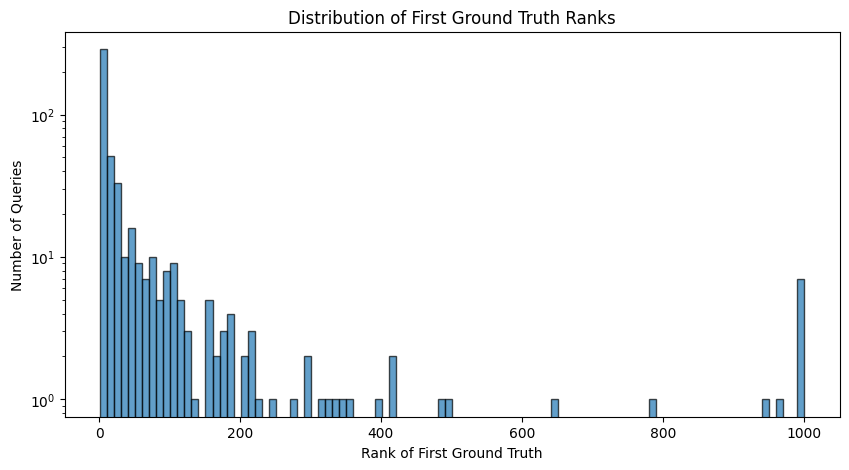

In [25]:
plt.figure(figsize=(10, 5))
plt.hist(result_df['First GT Rank'], bins=np.arange(1, 1002, 10), edgecolor="black", alpha=0.7)
plt.xlabel("Rank of First Ground Truth")
plt.ylabel("Number of Queries")
plt.title("Distribution of First Ground Truth Ranks")
plt.yscale("log")  
plt.show()


In [28]:
first_gt_ranks = result_df['First GT Rank'].tolist()

mrr = np.mean([1/rank for rank in first_gt_ranks if rank <= 1000])
print(f"Mean Reciprocal Rank (MRR): {mrr:.4f}")


Mean Reciprocal Rank (MRR): 0.3304


### Finding patterns in query results

In [6]:
correct_retrievals = df[df["ground_truth_relevance"] == 1]
incorrect_retrievals = df[df["ground_truth_relevance"] == 0]

/tmp/ipykernel_2252767/4025150044.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(incorrect_retrievals['score'], color='r', label='Incorrect Retrievals', shade=True, alpha=0.6)
/tmp/ipykernel_2252767/4025150044.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(correct_retrievals['score'], color='g', label='Correct Retrievals', shade=True, alpha=0.6)


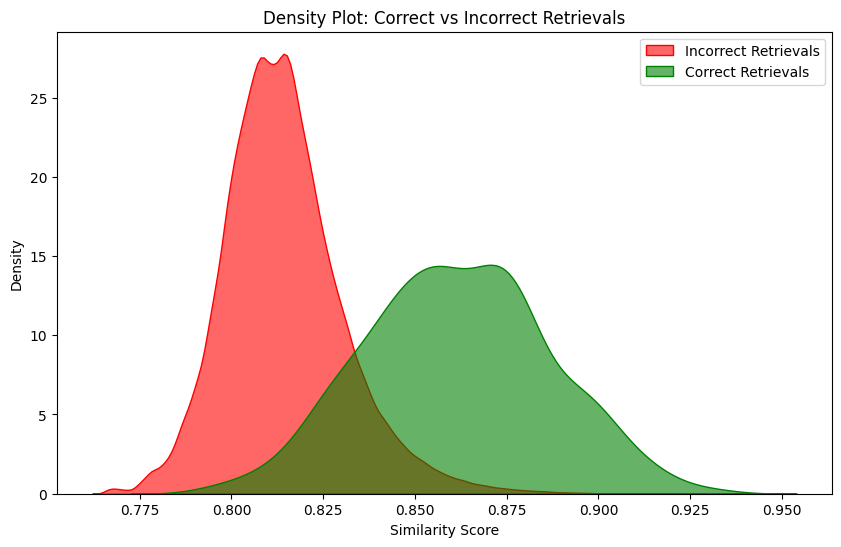

In [7]:
plt.figure(figsize=(10, 6))
sns.kdeplot(incorrect_retrievals['score'], color='r', label='Incorrect Retrievals', shade=True, alpha=0.6)
sns.kdeplot(correct_retrievals['score'], color='g', label='Correct Retrievals', shade=True, alpha=0.6)

plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.title('Density Plot: Correct vs Incorrect Retrievals')
plt.legend()
plt.show()


In [8]:
df['top_retrieved_score'] = df.groupby('query')['score'].transform('max')
df['score_difference'] = df['top_retrieved_score'] - df['score']

In [9]:
df['score_difference'].describe()

count    500000.000000
mean          0.068620
std           0.022143
min           0.000000
25%           0.053502
50%           0.067599
75%           0.083329
max           0.140608
Name: score_difference, dtype: float64

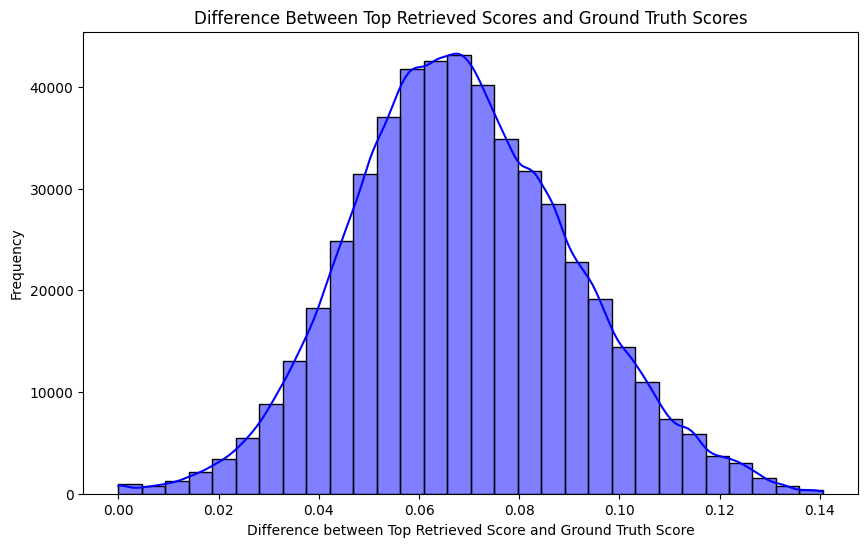

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(df['score_difference'], bins=30, kde=True, color='b')
plt.xlabel('Difference between Top Retrieved Score and Ground Truth Score')
plt.ylabel('Frequency')
plt.title('Difference Between Top Retrieved Scores and Ground Truth Scores')
plt.show()

### Analyzing Term Frequencies & BM25 Impact

In [44]:
def token_overlap(query, explanation):
    query_tokens = set(word for word in query.lower().split() if word not in stop_words)
    explanation_tokens = set(word for word in explanation.lower().split() if word not in stop_words)
    return len(query_tokens.intersection(explanation_tokens))

In [45]:
df["retrieved_overlap"] = df.apply(lambda row: token_overlap(row["query"], row["retrieved_explanation"]), axis=1)

df["ground_truth_overlap"] = df.apply(lambda row: token_overlap(row["query"], row["ground_truth_explanation"]) , axis=1)

In [46]:
df

,query_id,query,retrieved_doc_id,retrieved_doc,retrieved_code,retrieved_explanation,score,ground_truth_relevance,ground_truth_explanation,retrieved_overlap,ground_truth_overlap
0,q20105,sort by a token in string python,d20330,python read tokens from line,def get_tokens(line: str) -> Iterator[str]:\n ...,The doc and code explain a function called get...,0.857562,0,The doc and code both clean a string by splitt...,2,1
1,q20105,sort by a token in string python,d13945,invalid token python for an array,def append_position_to_token_list(token_list):...,The docstring and code snippet indicate that t...,0.856641,0,The doc and code both clean a string by splitt...,1,1
2,q20105,sort by a token in string python,d1629,loop through tokens in a string python,"def tokenize(string):\n """"""Match and yield ...",The docstring and code snippet are explaining ...,0.853523,0,The doc and code both clean a string by splitt...,2,1
3,q20105,sort by a token in string python,d20095,test the number of characters in python list,"def token_list_len(tokenlist):\n """"""\n R...",The doc string explains that the function toke...,0.852564,0,The doc and code both clean a string by splitt...,3,1
4,q20105,sort by a token in string python,d6211,sorting a list of python objects by an element...,"def csort(objs, key):\n """"""Order-preserving...",The docstring explains that the function sorts...,0.852503,0,The doc and code both clean a string by splitt...,1,1
...,...,...,...,...,...,...,...,...,...,...,...
499995,q20604,how do i unzip file in python,d17684,python judge if file empty,def isfile_notempty(inputfile: str) -> bool:\n...,The docstring and code snippet are providing a...,0.798209,0,The code snippet defines a function `_unzip_ha...,1,1
499996,q20604,how do i unzip file in python,d8895,python get name of file on s3,"def download_file_from_bucket(self, bucket, fi...",The code is designed to download a file from a...,0.798193,0,The code snippet defines a function `_unzip_ha...,1,1
499997,q20604,how do i unzip file in python,d19891,how to concatenate output in same file python,"def build_output(self, fout):\n """"""Squa...",The doc and code aim to concatenate the conten...,0.798187,0,The code snippet defines a function `_unzip_ha...,0,1
499998,q20604,how do i unzip file in python,d12297,python capture file creation date,"def datetime_created(self):\n """"""Return...",The doc and code snippet are related to captur...,0.798172,0,The code snippet defines a function `_unzip_ha...,1,1


In [15]:
print(token_overlap(df['query'][0],df['retrieved_explanation'][0]))

q:  {'string', 'python', 'token', 'sort'}
expl:  {'explain', 'splits', 'takes', 'input.', 'empty.the', 'non-empty.', 'yields', 'rstrip()', '`get_tokens`', 'input', '`rstrip()`', 'code', 'string', 'using', 'doc', 'function', 'tokens', 'called', 'token', 'get_tokens'}
2


In [47]:
retrieved_avg = df["retrieved_overlap"].mean()
ground_truth_avg = df["ground_truth_overlap"].mean()

print(f"Average Token Overlap - Retrieved Explanations: {retrieved_avg:.2f}")
print(f"Average Token Overlap - Ground Truth Explanations: {ground_truth_avg:.2f}")

Average Token Overlap - Retrieved Explanations: 0.68
Average Token Overlap - Ground Truth Explanations: 1.77


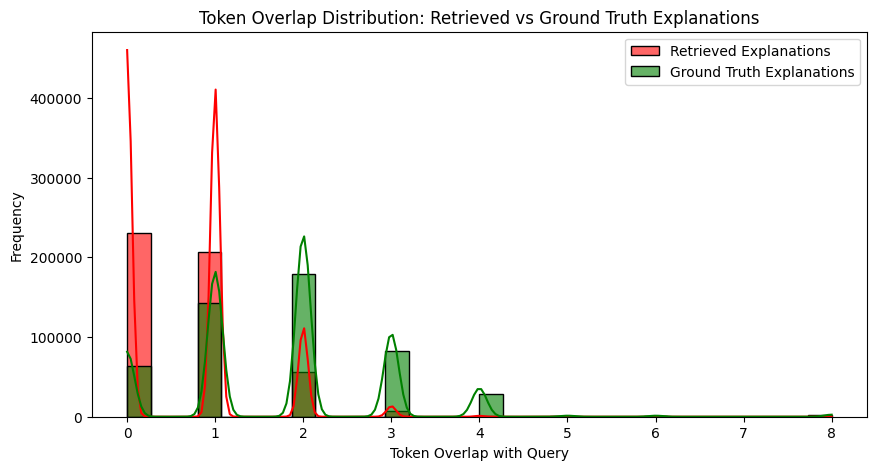

In [49]:
plt.figure(figsize=(10, 5))
sns.histplot(df["retrieved_overlap"], bins=30, color="red", label="Retrieved Explanations", alpha=0.6, kde=True)
sns.histplot(df["ground_truth_overlap"], bins=30, color="green", label="Ground Truth Explanations", alpha=0.6, kde=True)
plt.xlabel("Token Overlap with Query")
plt.ylabel("Frequency")
plt.title("Token Overlap Distribution: Retrieved vs Ground Truth Explanations")
plt.legend()
plt.show()

In [55]:
avg_query_token_size = df["query"].apply(lambda x: len([word for word in x.lower().split() if word not in stop_words])).mean()

print(f"Average Query Token Size: {avg_query_token_size:.2f}")

Average Query Token Size: 4.65


In [52]:
higher_gt_overlap = (df["ground_truth_overlap"] > df["retrieved_overlap"]).sum()
total_rows = len(df)

print(f"Ground Truth Overlap > Retrieved Overlap: {higher_gt_overlap}/{total_rows} ({(higher_gt_overlap/total_rows)*100:.2f}%)")

Ground Truth Overlap > Retrieved Overlap: 338500/500000 (67.70%)
